In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

D:\ANACONDA\ANA\envs\aiworks\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\ANACONDA\ANA\envs\aiworks\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\ANACONDA\ANA\envs\aiworks\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
DATASET = r"E:\1.2.Deeplearning\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
print("[INFO] loading images...")

[INFO] loading images...


In [7]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DATASET, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

D:\ANACONDA\ANA\envs\aiworks\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


In [11]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
for layer in baseModel.layers:
    layer.trainable = False

In [17]:
from tensorflow.keras.optimizers import legacy

print("[INFO] compiling model...")
opt = legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [19]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 640s 6s/step - loss: 0.4223 - accuracy: 0.8426 - val_loss: 0.1834 - val_accuracy: 0.9779
Epoch 2/20
96/96 [==============================] - 538s 6s/step - loss: 0.1715 - accuracy: 0.9560 - val_loss: 0.0986 - val_accuracy: 0.9831
Epoch 3/20
96/96 [==============================] - 669s 7s/step - loss: 0.1103 - accuracy: 0.9688 - val_loss: 0.0720 - val_accuracy: 0.9896
Epoch 4/20
96/96 [==============================] - 619s 6s/step - loss: 0.0806 - accuracy: 0.9767 - val_loss: 0.0600 - val_accuracy: 0.9896
Epoch 5/20
96/96 [==============================] - 550s 6s/step - loss: 0.0667 - accuracy: 0.9813 - val_loss: 0.0525 - val_accuracy: 0.9896
Epoch 6/20
96/96 [==============================] - 574s 6s/step - loss: 0.0643 - accuracy: 0.9806 - val_loss: 0.0494 - val_accuracy: 0.9883
Epoch 7/20
96/96 [==============================] - 518s 5s/step - loss: 0.0622 - accuracy: 0.9829 - val_loss: 0.0493 - val_accura

In [20]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

   
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

 
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
25/25 [==============================] - 95s 2s/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770

[INFO] saving mask detector model...


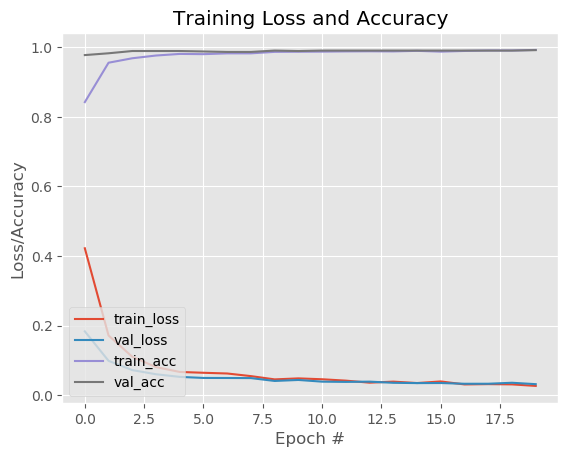

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")